In [1]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

import logging
logger = logging.getLogger('Twomes data extraction')
logger.setLevel(logging.NOTSET)



n_std_outliers = 3.0 # default for the multiplier of the the standard deviation; further out than this times the std, outliers are removed during preprocessing
up_intv = '5min' # the default upsampling interval that is used before interpolation is done
gap_n_intv = 11 # the default maximum number of consecutive NaNs to fill(one for each upsampling interval), i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more
sampling_interval = '15min' # the default interval on which interpolation will be done during preprocessing
moving_horizon_duration_d = 7
required_columns_for_sanity = ['home_id', 'T_out_e_avg_C', 'irradiation_hor_avg_W_p_m2', 'T_in_avg_C', 'gas_sup_avg_W', 'e_remaining_heat_avg_W', 'interval_s']
        

sanity_fraction = 0.5

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.50655, 6.09961

#timezone: 
timezone_database = 'UTC'
timezone_homes = 'Europe/Amsterdam'

# # # Below, the maximum period for data collection
# first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 25))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 8))

# Alternatively, you may want to test things only on a three week periode. This is a period with suitable weather and lots of homes with measurements.
first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 31))

# The full set of homes
homes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]

# # A subset of homes
# homes = [803422, 805164, 809743]

# single home for virtual homes
# homes = [886307]



100% 696/696 [00:11<00:00, 60.16it/s]


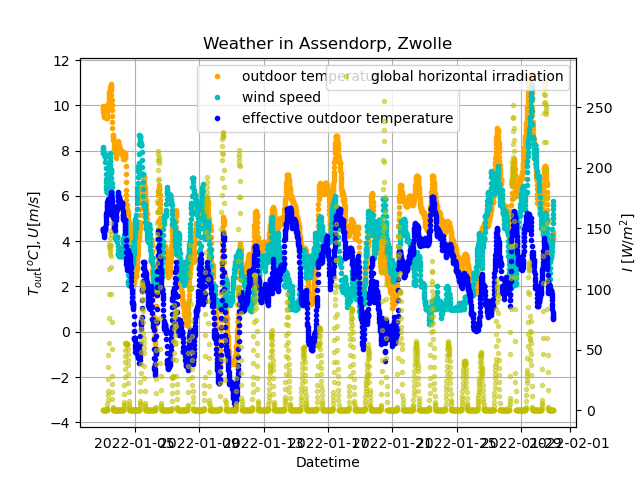

CPU times: user 16 s, sys: 1.16 s, total: 17.1 s
Wall time: 29.5 s


In [2]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time
tz_knmi='Europe/Amsterdam'

df_weather = WeatherExtractor.get_interpolated_weather_nl(first_day, last_day, lat, lon, tz_knmi, timezone_homes, sampling_interval)

# plot temperature data
logger.setLevel(logging.NOTSET)
Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [3]:
#see more statisctics about the weather data
df_weather.describe(include='all')

,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C
count,2689.000000,2689.000000,2689.000000,2689.000000
mean,4.590749,3.570400,24.110474,2.210483
std,2.317102,1.869339,48.384177,1.960516
min,-1.516613,0.344984,0.000000,-3.474642
25%,3.245127,2.085329,0.000000,0.959107
50%,4.648182,3.344984,0.000000,2.301242
75%,5.925771,4.785868,28.014803,3.642987
max,11.371349,10.914671,276.961532,6.176163


In [4]:
%%time 
# get interpolated data from the Twomes database and combine with weather data already obtained

logger.setLevel(logging.INFO)



df_data_homes = Extractor.get_preprocessed_homes_data(homes, first_day, last_day, timezone_database, timezone_homes,
                                                      up_intv, gap_n_intv, sampling_interval, 
                                                      required_columns_for_sanity,
                                                      df_weather)
filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
# ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, first_day.isoformat(),last_day.isoformat())))
Extractor.write_home_data_to_csv(df_data_homes, str('{0}-data_homes-{1}-{2}.csv'.format(filename_prefix, first_day.isoformat(),last_day.isoformat())))

logger.setLevel(logging.NOTSET)


  0%|          | 0/23 [00:00<?, ?it/s]

CPU times: user 45.9 s, sys: 491 ms, total: 46.4 s
Wall time: 24min 30s


In [ ]:
# %%time 
# # get interpolated data from the virtual homes and combine with weather data already obtained
# %autoreload 2
# logger.setLevel(logging.INFO)

# homes = [
#     60200, 
#     120100, 
#     150080, 
#     150100, 
#     200060, 
#     300040, 
#     400030, 
#     600020 
# ]

# # For virtual homes, only the following period is valid:
# first_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 24))

# df_data_homes = pd.DataFrame()
# for home_id in homes:
#     df_data_homes = pd.concat([df_data_homes, Extractor.get_virtual_home_data_csv(str('../data/virtualhome_P{0}.csv'.format(home_id)), timezone_homes)], axis=0)

# logger.setLevel(logging.NOTSET)


In [5]:
df_data_homes

T_out_avg_C  wind_avg_m_p_s  \
home_id  timestamp                                                
803422.0 2022-01-03 00:00:00+01:00     9.988781        8.170658   
         2022-01-03 00:15:00+01:00     9.938781        8.105744   
         2022-01-03 00:30:00+01:00     9.888781        8.040831   
         2022-01-03 00:45:00+01:00     9.838781        7.975917   
         2022-01-03 01:00:00+01:00     9.788781        7.911003   
...                                         ...             ...   
NaN      2022-01-31 22:45:00+01:00          NaN             NaN   
         2022-01-31 23:00:00+01:00          NaN             NaN   
         2022-01-31 23:15:00+01:00          NaN             NaN   
         2022-01-31 23:30:00+01:00          NaN             NaN   
         2022-01-31 23:45:00+01:00          NaN             NaN   

                                    irradiation_hor_avg_W_p_m2  T_out_e_avg_C  \
home_id  timestamp                                                              
803422.0 2022-01-03 00:00:00+01:00                         0.0       4.541676   
         2022-01-03 00:15:00+01:00                         0.0       4.534952   
         2022-01-03 00:30:00+01:00                         0.0       4.528227   
         2022-01-03 00:45:00+01:00                         0.0       4.521503   
         2022-01-03 01:00:00+01:00                         0.0       4.514779   
...                                                        ...            ...   
NaN      2022-01-31 22:45:00+01:00                         NaN            NaN   
         2022-01-31 23:00:00+01:00                         NaN            NaN   
         2022-01-31 23:15:00+01:00                         NaN            NaN   
         2022-01-31 23:30:00+01:00                         NaN            NaN   
         2022-01-31 23:45:00+01:00                         NaN            NaN   

                                    T_in_avg_C  T_set_first_C  interval_s  \
home_id  timestamp                                                          
803422.0 2022-01-03 00:00:00+01:00         NaN            NaN       900.0   
         2022-01-03 00:15:00+01:00         NaN            NaN       900.0   
         2022-01-03 00:30:00+01:00         NaN            NaN       900.0   
         2022-01-03 00:45:00+01:00         NaN            NaN       900.0   
         2022-01-03 01:00:00+01:00         NaN            NaN       900.0   
...                                        ...            ...         ...   
NaN      2022-01-31 22:45:00+01:00   20.100000           20.0       900.0   
         2022-01-31 23:00:00+01:00   20.100000           18.0       900.0   
         2022-01-31 23:15:00+01:00   20.063333           17.0       900.0   
         2022-01-31 23:30:00+01:00   19.990000           17.0       900.0   
         2022-01-31 23:45:00+01:00   19.990000           17.0       900.0   

                                    gas_sup_avg_W  e_used_avg_W  \
home_id  timestamp                                                
803422.0 2022-01-03 00:00:00+01:00       0.000000         284.0   
         2022-01-03 00:15:00+01:00       0.000000         308.0   
         2022-01-03 00:30:00+01:00       0.000000         296.0   
         2022-01-03 00:45:00+01:00       0.000000         188.0   
         2022-01-03 01:00:00+01:00    1416.569444          76.0   
...                                           ...           ...   
NaN      2022-01-31 22:45:00+01:00      39.077778         768.0   
         2022-01-31 23:00:00+01:00       0.000000         820.0   
         2022-01-31 23:15:00+01:00       0.000000         256.0   
         2022-01-31 23:30:00+01:00       0.000000         320.0   
         2022-01-31 23:45:00+01:00      39.077778        1564.0   

                                    e_returned_avg_W  e_remaining_heat_avg_W  \
home_id  timestamp                                                             
803422.0 2022-01-03 00:00:00+01:00               0.0                   284.0

In [6]:
# present some sanity metrics for the extracted data
total_measurement_time = timedelta(seconds = int(df_data_homes['interval_s'].sum()))
print('Total measurement time: ', total_measurement_time)
sane_fraction = df_data_homes['sanity_frac'].mean()
print('Sane fraction measurement time: {:.2f}'.format(sane_fraction))
sane_measurement_time = total_measurement_time * sane_fraction
print('Sane  measurement time: ', sane_measurement_time)

#see more statisctics
df_data_homes.describe(include='all')

Total measurement time:  638 days, 0:00:00
Sane fraction measurement time: 0.63
Sane  measurement time:  403 days, 12:30:00


,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C,T_in_avg_C,T_set_first_C,interval_s,gas_sup_avg_W,e_used_avg_W,e_returned_avg_W,e_remaining_heat_avg_W,sanity_frac
count,59158.000000,59158.000000,59158.000000,59158.000000,43330.000000,19580.000000,61248.0,48205.000000,48222.000000,48222.000000,48222.000000,61248.000000
mean,4.590749,3.570400,24.110474,2.210483,18.718822,14.015089,900.0,2014.216881,294.492977,14.417566,280.075411,0.632478
std,2.316690,1.869007,48.375588,1.960167,1.510494,6.908095,0.0,2754.187027,427.009724,103.697537,447.055555,0.482134
min,-1.516613,0.344984,0.000000,-3.474642,13.455000,0.000000,900.0,0.000000,0.000000,0.000000,-2612.000000,0.000000
25%,3.245127,2.085329,0.000000,0.959107,17.740000,12.500000,900.0,0.000000,84.000000,0.000000,80.000000,0.000000
50%,4.648182,3.344984,0.000000,2.301242,18.836667,17.000000,900.0,791.325000,152.000000,0.000000,152.000000,1.000000
75%,5.925771,4.785868,28.014803,3.642987,20.000000,18.500000,900.0,3165.300000,312.000000,0.000000,308.000000,1.000000
max,11.371349,10.914671,276.961532,6.176163,23.223333,38.360000,900.0,21531.855556,5692.000000,2612.000000,5692.000000,1.000000


In [ ]:
# %%time 
# from tqdm import tqdm_notebook

# %autoreload 2
# filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")

# first_day = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 25))
# last_day = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 8))

# df_rawdata = pd.DataFrame()
# home_iterator = tqdm_notebook(homes)

# for home_id in home_iterator:
#     # print('Processing ', home_id)
#     extractor = Extractor(home_id, Period(first_day, last_day))
#     df_rawdata = extractor.get_rawdata()
#     df_rawdata.describe(include='all')
#     Extractor.write_raw_data_to_csv(df_rawdata, str('{0}-rawdata_P{1}-{2}-{3}.csv'.format(filename_prefix, home_id, first_day.isoformat(),last_day.isoformat())))



In [7]:
df_data_homes.describe(include='all')

,T_out_avg_C,wind_avg_m_p_s,irradiation_hor_avg_W_p_m2,T_out_e_avg_C,T_in_avg_C,T_set_first_C,interval_s,gas_sup_avg_W,e_used_avg_W,e_returned_avg_W,e_remaining_heat_avg_W,sanity_frac
count,59158.000000,59158.000000,59158.000000,59158.000000,43330.000000,19580.000000,61248.0,48205.000000,48222.000000,48222.000000,48222.000000,61248.000000
mean,4.590749,3.570400,24.110474,2.210483,18.718822,14.015089,900.0,2014.216881,294.492977,14.417566,280.075411,0.632478
std,2.316690,1.869007,48.375588,1.960167,1.510494,6.908095,0.0,2754.187027,427.009724,103.697537,447.055555,0.482134
min,-1.516613,0.344984,0.000000,-3.474642,13.455000,0.000000,900.0,0.000000,0.000000,0.000000,-2612.000000,0.000000
25%,3.245127,2.085329,0.000000,0.959107,17.740000,12.500000,900.0,0.000000,84.000000,0.000000,80.000000,0.000000
50%,4.648182,3.344984,0.000000,2.301242,18.836667,17.000000,900.0,791.325000,152.000000,0.000000,152.000000,1.000000
75%,5.925771,4.785868,28.014803,3.642987,20.000000,18.500000,900.0,3165.300000,312.000000,0.000000,308.000000,1.000000
max,11.371349,10.914671,276.961532,6.176163,23.223333,38.360000,900.0,21531.855556,5692.000000,2612.000000,5692.000000,1.000000


In [8]:
%%time 
%autoreload 2


sanity_fraction_analysis = sanity_fraction

# Use one of the lines below to set the moving horizon duration used for analysis 
# moving_horizon_duration_d_analysis = 14
moving_horizon_duration_d_analysis = moving_horizon_duration_d


# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, 
                                                         n_std_outliers, up_intv, gap_n_intv, sampling_interval, 
                                                         moving_horizon_duration_d_analysis, sanity_fraction_analysis,
                                                         hint_A_m2=None, ev_type=2)



Homes to analyse:  Float64Index([803422.0, 805164.0, 809743.0, 811308.0, 815925.0, 817341.0,
              822479.0, 829947.0, 830088.0, 831062.0, 839440.0, 845966.0,
              845997.0, 846697.0, 857477.0, 864296.0, 873985.0, 879481.0,
              886307.0, 895671.0, 897349.0, 899510.0],
             dtype='float64', name='home_id')
Start of analyses:  2022-01-03 00:00:00+01:00
End of analyses:  2022-01-31 23:45:00+01:00
Moving horizon:  7D
#standard deviations for outlier removal:  3.0
Upsampling_interval:  5min
#upsampling intervals bridged during interpolation (max):  11
Interpolation interval:  15min
Hint for effective window are A [m^2]:  None
Hint for superior heating efficiency eta [-]:  0.97
EV_TYPE:  2


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 803422.0 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 803422.0 in period from 2022-01-31 00:00:00+01:00 to 2022-01-31 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 805164.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 815925.0 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 815925.0 in period from 2022-01-31 00:00:00+01:00 to 2022-01-31 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 817341.0 in period from 2022-01-03 00:00:00+01:00 to 2022-01-09 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 839440.0 in period from 2022-01-03 00:00:00+01:00 to 2022-01-09 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 845966.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 845997.0 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 845997.0 in period from 2022-01-31 00:00:00+01:00 to 2022-01-31 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-01-24 00:00:00+01:00 to 2022-01-30 23:45:00+01:00; skipping...
ERROR:root:Exception @error: Solution Not Found
 for home 846697.0 in period from 2022-01-31 00:00:00+01:00 to 2022-01-31 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 864296.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

ERROR:root:Exception @error: Solution Not Found
 for home 897349.0 in period from 2022-01-17 00:00:00+01:00 to 2022-01-23 23:45:00+01:00; skipping...


  0%|          | 0/5 [00:00<?, ?it/s]

DONE: Analysis of all homes complete; writing files.
         T_out_avg_C  wind_avg_m_p_s  irradiation_hor_avg_W_p_m2  \
count   46368.000000    46368.000000                46368.000000   
unique           NaN             NaN                         NaN   
top              NaN             NaN                         NaN   
freq             NaN             NaN                         NaN   
mean        4.822562        3.659996                   24.808561   
std         2.254641        2.061170                   50.918483   
min        -1.516613        0.344984                    0.000000   
25%         3.408991        1.957335                    0.000000   
50%         4.724442        3.365399                    0.000000   
75%         6.108533        5.120280                   28.234899   
max        11.371349       10.914671                  276.961532   

        T_out_e_avg_C    T_in_avg_C  T_set_first_C  interval_s  gas_sup_avg_W  \
count    46368.000000  45541.000000   18351.00000

In [ ]:
#show the results
df_results

In [ ]:
# plot temperature data of multiple homes from an array 
# # %autoreload 2
# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('T_in_avg_C','r'),('T_set_first_C','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes_to_analyze:
#     df_data_one_home = df_data_homes.loc[home_id]
#     for moving_horizon_start in pd.date_range(start=first_day, end=first_day, inclusive='left', freq='7D'):
#         moving_horizon_end = min(first_day, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    

In [ ]:
# how to select data from a single home
# df_data_homes.loc[817341]